[Table of Contents](http://nbviewer.ipython.org/github/rlabbe/Kalman-and-Bayesian-Filters-in-Python/blob/master/table_of_contents.ipynb)

# Ensemble Kalman Filters

In [1]:
#format the book
%matplotlib inline
%load_ext autoreload
%autoreload 2  
from __future__ import division, print_function
import sys
sys.path.insert(0,'./code')
from book_format import load_style, set_figsize, figsize
load_style()

> I am not well versed with Ensemble filters. I have implemented one for this book, and made it work, but I have not used one in real life. Different sources use slightly different forms of these equations. If I implement the equations given in the sources the filter does not work. It is possible that I am doing something wrong. However, in various places on the web I have seen comments by people stating that they do the kinds of things I have done in my filter to make it work. In short, I do not understand this topic well, but choose to present my lack of knowledge rather than to gloss over the subject. I hope to master this topic in the future and to author a more definitive chapter. At the end of the chapter I document my current confusion and questions. In any case if I got confused by the sources perhaps you also will, so documenting my confusion can help you avoid the same.


The ensemble Kalman filter (EnKF) is very similar to the unscented Kalman filter (UKF) of the last chapter. If you recall, the UKF uses a set of deterministically chosen weighted sigma points passed through nonlinear state and measurement functions. After the sigma points are passed through the function, we find the mean and covariance of the points and use this as the filter's new mean and covariance. It is only an approximation of the true value, and thus suboptimal, but in practice the filter is highly accurate. It has the advantage of often producing more accurate estimates than the EKF does, and also does not require you to analytically derive the linearization of the state and measurement equations. 

The ensemble Kalman filter works in a similar way, except it uses a *Monte Carlo* method to choose a large numbers of sigma points. It came about from the geophysical sciences as an answer for the very large states and systems needed to model things such as the ocean and atmosphere. There is an interesting article on it's development in weather modeling in *SIAM News* [1]. The filter starts by randomly generating a large number of points distributed about the filter's initial state. This distribution is proportional to the filter's covariance $\mathbf{P}$. In other words 68% of the points will be within one standard deviation of the mean, 95% percent within two standard deviations, and so on. Let's look at this in two dimensions. We will use `numpy.random.multivariate_normal()` function to randomly create points from a multivariate normal distribution drawn from the mean (5, 3) with the covariance

$$\begin{bmatrix}
32 & 15 \\ 15 & 40
\end{bmatrix}$$

I've drawn the covariance ellipse representing two standard deviations to illustrate how the points are distributed.

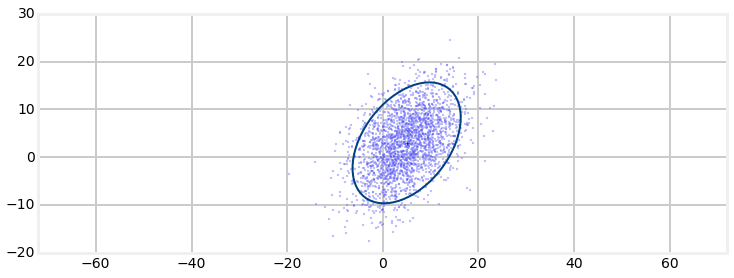

In [2]:
import matplotlib.pyplot as plt
import numpy as np
from numpy.random import multivariate_normal
from filterpy.stats import (covariance_ellipse, 
                            plot_covariance_ellipse)

mean = (5, 3)
P = np.array([[32, 15],
              [15., 40.]])

x,y = multivariate_normal(mean=mean, cov=P, size=2500).T
plt.scatter(x, y, alpha=0.3, marker='.')
plt.axis('equal')

plot_covariance_ellipse(mean=mean, cov=P,
                        variance=2.**2,
                        facecolor='none')

## The Algorithm

As I already stated, when the filter is initialized a large number of sigma points are drawn from the initial state ($\mathbf{x}$) and covariance ($\mathbf{P}$). From there the algorithm proceeds very similarly to the UKF. During the prediction step the sigma points are passed through the state transition function, and then perturbed by adding a bit of noise to account for the process noise. During the update step the sigma points are translated into measurement space by passing them through the measurement function, they are perturbed by a small amount to account for the measurement noise. The Kalman gain is computed from the 

We already mentioned the main difference between the UKF and EnKF - the UKF choses the sigma points deterministically. There is another difference, implied by the algorithm above. With the UKF we generate new sigma points during each predict step, and after passing the points through the nonlinear function we reconstitute them into a mean and covariance by using the *unscented transform*. The EnKF just keeps propagating the originally created sigma points; we only need to compute a mean and covariance as outputs for the filter! 

Let's look at the equations for the filter. As usual, I will leave out the typical subscripts and superscripts; I am expressing an algorithm, not mathematical functions. Here $N$ is the number of sigma points, $\chi$ is the set of sigma points.

### Initialize Step

$$\boldsymbol\chi \sim \mathcal{N}(\mathbf{x}_0, \mathbf{P}_0)$$

This just says to select the sigma points from the filter's initial mean and covariance. In code this might look like

    N = 1000
    sigmas = multivariate_normal(mean=x, cov=P, size=N)

### Predict Step

$$
\begin{aligned}
\boldsymbol\chi &= f(\boldsymbol\chi, \mathbf{u}) + v_Q \\
\mathbf{x} &= \frac{1}{N} \sum_1^N \boldsymbol\chi
\end{aligned}
$$

That is short and sweet, but perhaps not entirely clear. The first line passes all of the sigma points through a use supplied state transition function and then adds some noise distributed according to the $\mathbf{Q}$ matrix. In Python we might write

    for i, s in enumerate(sigmas):
        sigmas[i] = fx(x=s, dt=0.1, u=0.)

    sigmas += multivariate_normal(x, Q, N)

The second line computes the mean from the sigmas. In Python we will take advantage of `numpy.mean` to do this very concisely and quickly.

    x = np.mean(sigmas, axis=0)

We can now optionally compute the covariance of the mean. The algorithm does not need to compute this value, but it is often useful for analysis. The equation is

$$\mathbf{P} = \frac{1}{N-1}\sum_1^N[\boldsymbol\chi-\mathbf{x}^-][\boldsymbol\chi-\mathbf{x}^-]^\mathsf{T}$$

$\boldsymbol\chi-\mathbf{x}^-$ is a one dimensional vector, so we will use `numpy.outer` to compute the $[\boldsymbol\chi-\mathbf{x}^-][\boldsymbol\chi-\mathbf{x}^-]^\mathsf{T}$ term. In Python we might write

    P = 0
    for s in sigmas:
        P += outer(s-x, s-x)
    P = P / (N-1)

### Update Step

In the update step we pass the sigma points through the measurement function, compute the mean and covariance of the sigma points, compute the Kalman gain from the covariance, and then update the Kalman state by scaling the residual by the Kalman gain. The equations are

$$
\begin{aligned}
\boldsymbol\chi_h &= h(\boldsymbol\chi, u)\\
\mathbf{z}_{mean} &= \frac{1}{N}\sum_1^N \boldsymbol\chi_h \\ \\
\mathbf{P}_{zz} &= \frac{1}{N-1}\sum_1^N [\boldsymbol\chi_h - \mathbf{z}_{mean}][\boldsymbol\chi_h - \mathbf{z}_{mean}]^\mathsf{T} + \mathbf{R} \\
\mathbf{P}_{xz} &= \frac{1}{N-1}\sum_1^N [\boldsymbol\chi - \mathbf{x}^-][\boldsymbol\chi_h - \mathbf{z}_{mean}]^\mathsf{T} \\
\\
\mathbf{K} &= \mathbf{P}_{xz} \mathbf{P}_{zz}^{-1}\\ 
\boldsymbol\chi & = \boldsymbol\chi + \mathbf{K}[\mathbf{z} -\boldsymbol\chi_h + \mathbf{v}_R] \\ \\
\mathbf{x} &= \frac{1}{N} \sum_1^N \boldsymbol\chi \\
\mathbf{P} &= \mathbf{P} - \mathbf{KP}_{zz}\mathbf{K}^\mathsf{T}
\end{aligned}
$$

This is very similar to the linear KF and the UKF. Let's just go line by line.

The first line,

$$\boldsymbol\chi_h = h(\boldsymbol\chi, u),$$

just passes the sigma points through the measurement function $h$. We name the resulting points $\chi_h$ to distinguish them from the sigma points. In Python we could write this as

    sigmas_h = h(sigmas, u)

The next line computes the mean of the measurement sigmas.

$$\mathbf{z}_{mean} = \frac{1}{N}\sum_1^N \boldsymbol\chi_h$$

In Python we can compute that with

    z_mean = np.mean(sigmas_h, axis=0)
    
Now that we have the mean of the measurement sigmas we can compute the covariance for every measurement sigma point, and the *cross variance* for the measurement sigma points vs the sigma points. That is expressed by these two equations

$$
\begin{aligned}
\mathbf{P}_{zz} &= \frac{1}{N-1}\sum_1^N [\boldsymbol\chi_h - \mathbf{z}_{mean}][\boldsymbol\chi_h - \mathbf{z}_{mean}]^\mathsf{T} + \mathbf{R} \\
\mathbf{P}_{xz} &= \frac{1}{N-1}\sum_1^N [\boldsymbol\chi - \mathbf{x}^-][\boldsymbol\chi_h - \mathbf{z}_{mean}]^\mathsf{T}
\end{aligned}$$

We can express this in Python with

    P_zz = 0
    for sigma in sigmas_h:
        s = sigma - z_mean
        P_zz += outer(s, s)
    P_zz = P_zz / (N-1) + R

    P_xz = 0
    for i in range(N):
        P_xz += outer(self.sigmas[i] - self.x, sigmas_h[i] - z_mean)
    P_xz /= N-1

Computation of the Kalman gain is straightforward $\mathbf{K} = \mathbf{P}_{xz} \mathbf{P}_{zz}^{-1}$.

In Python this is the trivial

    K = np.dot(P_xz, inv(P_zz))

Next, we update the sigma points with

$$\boldsymbol\chi  = \boldsymbol\chi + \mathbf{K}[\mathbf{z} -\boldsymbol\chi_h + \mathbf{v}_R]$$ 

Here $\mathbf{v}_R$ is the perturbation that we add to the sigmas. In Python we can implement this with

    v_r = multivariate_normal([0]*dim_z, R, N)
    for i in range(N):
        sigmas[i] += dot(K, z + v_r[i] - sigmas_h[i])


Our final step is recompute the filter's mean and covariance.

        x = np.mean(sigmas, axis=0)
        P = self.P - dot3(K, P_zz, K.T)

## Implementation and Example

I have implemented an EnKF in the `FilterPy` library. It is in many ways a toy. Filtering with a large number of sigma points gives us very slow performance. Furthermore, there are many minor variations on the algorithm in the literature. I wrote this mostly because I was interested in learning a bit about the filter. I have not used it for a real world problem, and I can give no advice on using the filter for the large problems for which it is suited. Therefore I will refine my comments to implementing a very simple filter. I will use it to track an object in one dimension, and compare the output to a linear Kalman filter. This is a filter we have designed many times already in this book, so I will design it with little comment. Our state vector will be

$$\mathbf{x} = \begin{bmatrix}x\\ \dot{x}\end{bmatrix}$$

The state transition function is

$$\mathbf{F} = \begin{bmatrix}1&1\\0&1\end{bmatrix}$$

and the measurement function is

$$\mathbf{H} = \begin{bmatrix}1&0\end{bmatrix}$$

The EnKF is designed for nonlinear problems, so instead of using matrices to implement the state transition and measurement functions you will need to supply Python functions. For this problem they can be written as:

    def hx(x):
        return np.array([x[0]])

    def fx(x, dt):
        return np.dot(F, x)
        
One final thing: the EnKF code, like the UKF code, uses a single dimension for $\mathbf{x}$, not a two dimensional column matrix as used by the linear kalman filter code.

Without further ado, here is the code.

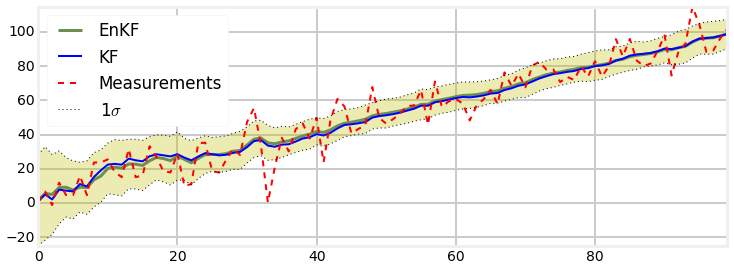

In [3]:
from numpy.random import randn
from filterpy.kalman import EnsembleKalmanFilter as EnKF
from filterpy.kalman import KalmanFilter
from filterpy.common import Q_discrete_white_noise
import book_plots as bp

np.random.seed(1234)

def hx(x):
    return np.array([x[0]])

def fx(x, dt):
    return np.dot(F, x)
    
F = np.array([[1., 1.],[0., 1.]])

x = np.array([0., 1.])
P = np.eye(2) * 100.
enf = EnKF(x=x, P=P, dim_z=1, dt=1., N=20, hx=hx, fx=fx)

std_noise = 10.
enf.R *= std_noise**2
enf.Q = Q_discrete_white_noise(2, 1., .001)

kf = KalmanFilter(dim_x=2, dim_z=1)
kf.x = np.array([x]).T
kf.F = F.copy()
kf.P = P.copy()
kf.R = enf.R.copy()
kf.Q = enf.Q.copy()
kf.H = np.array([[1., 0.]])

measurements = []
results = []
ps = []
kf_results = []

zs = []
for t in range (0,100):
    # create measurement = t plus white noise
    z = t + randn()*std_noise
    zs.append(z)

    enf.predict()
    enf.update(np.asarray([z]))
    
    kf.predict()
    kf.update(np.asarray([[z]]))

    # save data
    results.append (enf.x[0])
    kf_results.append (kf.x[0,0])
    measurements.append(z)
    ps.append(3*(enf.P[0,0]**.5))

results = np.asarray(results)
ps = np.asarray(ps)

plt.plot(results, label='EnKF')
plt.plot(kf_results, label='KF', c='b', lw=2)
bp.plot_measurements(measurements)
plt.plot (results - ps, c='k',linestyle=':', lw=1, label='1$\sigma$')
plt.plot(results + ps, c='k', linestyle=':', lw=1)
plt.fill_between(range(100), results - ps, results + ps, facecolor='y', alpha=.3)
plt.legend(loc='best');

It can be a bit difficult to see, but the KF and EnKF start off slightly different, but soon converge to producing nearly the same values. The EnKF is a suboptimal filter, so it will not produce the optimal solution that the KF produces. However, I deliberately chose $N$ to be quite small (20) to guarantee that the EnKF output is quite suboptimal. If I chose a more reasonable number such as 2000 you would be unable to see the difference between the two filter outputs on this graph.

## Outstanding Questions

All of this should be considered as *my* questions, not lingering questions in the literature. However, I am copying equations directly from well known sources in the field, and they do not address the discrepancies.

First, in Brown [2] we have all sums multiplied by $\frac{1}{N}$, as in 

$$ \hat{x} = \frac{1}{N}\sum_{i=1}^N\chi_k^{(i)}$$

The same equation in Crassidis [3] reads (I'll use the same notation as in Brown, although Crassidis' is different)

$$ \hat{x} = \frac{1}{N-1}\sum_{i=1}^N\chi_k^{(i)}$$

The same is true in both sources for the sums in the computation for the covariances. Crassidis, in the context of talking about the filter's covariance, states that $N-1$ is used to ensure an unbiased estimate. Given the following standard equations for the mean and standard deviation (p.2 of Crassidis), this makes sense for the covariance.

$$
\begin{aligned}
\mu &= \frac{1}{N}\sum_{i=1}^N[\tilde{z}(t_i) - \hat{z}(t_i)] \\
 \sigma^2 &= \frac{1}{N-1}\sum_{i=1}^N\{[\tilde{z}(t_i) - \hat{z}(t_i)] - \mu\}^2
\end{aligned}
$$

However, I see no justification or reason to use $N-1$ to compute the mean. If I use $N-1$ in the filter for the mean the filter does not converge and the state essentially follows the measurements without any filtering. However, I do see a reason to use it for the covariance as in Crassidis, in contrast to Brown. Again, I support my decision empirically - $N-1$ works in the implementation of the filter, $N$ does not.

My second question relates to the use of the $\mathbf{R}$ matrix. In Brown $\mathbf{R}$ is added to $\mathbf{P}_{zz}$ whereas it isn't in Crassidis and other sources. I have read on the web notes by other implementers that adding R helps the filter, and it certainly seems reasonable and necessary to me, so this is what I do. 

My third question relates to the computation of the covariance $\mathbf{P}$. Again, we have different equations in Crassidis and Brown. I have chosen the implementation given in Brown as it seems to give me the  behavior that I expect (convergence of $\mathbf{P}$ over time) and it closely compares to the form in the linear KF. In contrast I find the equations in Crassidis do not seem to converge much.

My fourth question relates to the state estimate update. In Brown we have 

$$\boldsymbol\chi  = \boldsymbol\chi + \mathbf{K}[\mathbf{z} -\mathbf{z}_{mean} + \mathbf{v}_R]$$ 

whereas in Crassidis we have

$$\boldsymbol\chi  = \boldsymbol\chi + \mathbf{K}[\mathbf{z} -\boldsymbol\chi_h + \mathbf{v}_R]$$ 

To me the Crassidis equation seems logical, and it produces a filter that performs like the linear KF for linear problems, so that is the formulation that I have chosen. 

I am not comfortable saying either book is wrong; it is quite possible that I missed some point that makes each set of equations work. I can say that when I implemented them as written I did not get a filter that worked. I define "work" as performs essentially the same as the linear KF for linear problems. Between reading implementation notes on the web and reasoning about various issues I have chosen the implementation in this chapter, which does in fact seem to work correctly. I have yet to explore the significant amount of original literature that will likely definitively explain the discrepancies. I would like to leave this here in some form even if I do find an explanation that reconciles the various differences, as if I got confused by these books than probably others will as well.

## References

- [1] Mackenzie, Dana. *Ensemble Kalman Filters Bring Weather Models Up to Date* Siam News,  Volume 36, Number 8, October 2003. http://www.siam.org/pdf/news/362.pdf

- [2]  Brown, Robert Grover, and Patrick Y.C. Hwang. *Introduction to Random Signals and Applied Kalman Filtering, With MATLAB® excercises and solutions.* Wiley, 2012.

- [3] Crassidis, John L., and John L. Junkins. *Optimal estimation of dynamic systems*. CRC press, 2011.